<a href="https://colab.research.google.com/github/DrAlexSanz/nlp-demystified/blob/main/Fake_news_detection_RNN_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import pandas as pd
import spacy
from sklearn.feature_extraction.text import strip_accents_ascii, strip_accents_unicode

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.layers import SimpleRNN, LSTM, GRU, Embedding, Dense
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from tensorflow import keras
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Import data
Easier to download from kaggle and upload to my drive in this case

In [3]:
raw_train = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/train.csv", encoding = "utf8", nrows = 10000) # Otherwise it will never finish tokenizing or training

raw_train["text"] = raw_train["text"].astype(str) # so the tokenizer doesn't complain when it finds a number. Alternatively, remove all the numbers.
#raw_test = pd.read_csv("/content/drive/MyDrive/Datasets/fake_news/test.csv") # Test dataset is to send to kaggle originally. I don't need this here.
raw_train.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

In [4]:
text = raw_train["text"].apply(lambda x: strip_accents_unicode(x))
text = text.apply(lambda x: strip_accents_ascii(x))
labels = raw_train["label"]

x_train, x_test, y_train, y_test = train_test_split(text, labels, test_size = 0.15)

In [6]:
nlp = spacy.load("en_core_web_sm", exclude = ["tok2vec", "tagger", "attribute_ruler", "lemmatizer", "ner", "parser"]) # Remove what I don't need.
# Fit on texts takes 8s with 1000 articles when I disable this. If it runs everything it takes 2 minutes, still with the same 1000 articles.
print(nlp.pipe_names)

def spacy_tokenizer(doc):
  # use .lemma_ instead of .text to reduce memory footprint
  transformed = [t.text.lower() for t in nlp(doc) if \
                not t.is_space and \
                not t.is_stop and \
                t.is_alpha]

  return transformed

[]


In [7]:
sentence_tokenizer = keras.preprocessing.text.Tokenizer(oov_token='', lower = True, analyzer = spacy_tokenizer) # The keras tokenizer is very simple and it works for many use cases. I can improve it a bit.
sentence_tokenizer.fit_on_texts(x_train) # Since the fitting is using the spacy tokenizer it will take much longer.

In [8]:
# And see how big is the vocabulary. Probably it would be a good idea to lemmatize or put a word limit because 238K words is not too smart
# Also, the keras tokenizer leaves all the 's and weird characters as unicode. I can probably solve it better but at least I will use the spacy tokenizer.

print(f"The vocabulary size is: {len(sentence_tokenizer.word_index)}")

The vocabulary size is: 100830


In [9]:
sentence_tokenizer.get_config() # I didn't realize that there are news in spanish and probably other languages.

{'num_words': None,
 'filters': '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
 'lower': True,
 'split': ' ',
 'char_level': False,
 'oov_token': '',
 'document_count': 8500,
 'word_counts': '{"share": 1366, "twitter": 2891, "video": 1891, "released": 1398, "donald": 4198, "trump": 18418, "grab": 133, "remarks": 438, "media": 4706, "outlets": 295, "focused": 494, "mounting": 110, "sexual": 813, "assault": 589, "allegations": 394, "republican": 3112, "nominee": 865, "fox": 1097, "news": 6076, "host": 718, "megyn": 95, "kelly": 542, "exception": 152, "recently": 1436, "asking": 575, "house": 5006, "speaker": 436, "surrogate": 46, "newt": 65, "gingrich": 115, "reason": 1330, "falling": 242, "polls": 798, "snapped": 47, "explained": 547, "sick": 289, "people": 14871, "like": 10958, "inflammatory": 58, "language": 586, "argued": 527, "issue": 1496, "proves": 102, "fascinated": 33, "sex": 727, "wanna": 26, "tapes": 34, "nt": 15575, "care": 1904, "public": 4238, "policy": 2824, "s": 8001, "watching"

In [10]:
# And if I want to see how the first article looks like:

x_train_seqs = sentence_tokenizer.texts_to_sequences(x_train)
x_test_seqs = sentence_tokenizer.texts_to_sequences(x_test)
#print(f"Reconstructed: {sentence_tokenizer.sequences_to_texts([x_train_seqs[0]])}") #If I want to recover the words
x_train_seqs[0][:10] # Show just a few.

[325, 79, 193, 313, 41, 3, 4184, 1427, 33, 2110]

## Pad the sequences to make sure I have consistent lengths.

In [11]:
list_lengths = [len(art) for art in x_train_seqs] # This is a list of lists

MAX_LENGTH = max(list_lengths)
print(f"The maximum length for an article is {MAX_LENGTH}")

The maximum length for an article is 9340


In [12]:
x_train_padded = pad_sequences(x_train_seqs, maxlen = MAX_LENGTH, padding = "post")
x_test_padded = pad_sequences(x_test_seqs, maxlen = MAX_LENGTH, padding = "post")

## Now I can start defining my RNN to classify my articles.

* I'll use an embedding layer and I can train it because I have enough data.
* Second version will be with pretrained embeddings to see the difference.
* Also make a bidirectional or a GRU and try to improve from the baseline case.

In [14]:
input_dim = len(sentence_tokenizer.word_index) + 1 # +1 to account for the padding token
embedding_dim = 128 # Try to reduce these to reduce memory and train time.

tf.random.set_seed(0)

RNN_base = keras.Sequential()

RNN_base.add(Embedding(input_dim = input_dim,
                              output_dim = embedding_dim,
                              input_length = MAX_LENGTH,
                              mask_zero = True)
            )

RNN_base.add(SimpleRNN(units = 64,
                       kernel_initializer = tf.keras.initializers.random_normal(seed=1))
            )

#RNN_base.add(Dense(32, activation = "relu")) # This is not really necessary but I keep it because I can.
            

RNN_base.add(Dense(1, activation="sigmoid")
            )

RNN_base.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

RNN_base.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 9340, 128)         12906368  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 12,918,785
Trainable params: 12,918,785
Non-trainable params: 0
_________________________________________________________________


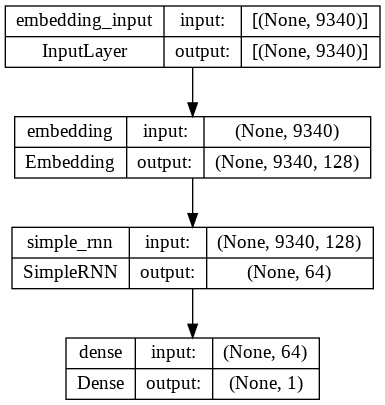

In [15]:
plot_model(RNN_base, show_shapes=True, show_layer_names=True)

## And now I train this thing

In [16]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = RNN_base.fit(x_train_padded, y_train, epochs=20, 
                    batch_size=512, validation_data=(x_test_padded, y_test), 
                    callbacks=[es_callback])

Epoch 1/20
17/17 [==============================] - 342s 20s/step - loss: 0.6671 - accuracy: 0.5974 - val_loss: 0.6287 - val_accuracy: 0.7033
Epoch 2/20
17/17 [==============================] - 336s 20s/step - loss: 0.4780 - accuracy: 0.9284 - val_loss: 0.5257 - val_accuracy: 0.7507
Epoch 3/20
17/17 [==============================] - 336s 20s/step - loss: 0.2838 - accuracy: 0.9622 - val_loss: 0.4384 - val_accuracy: 0.7927
Epoch 4/20
17/17 [==============================] - 336s 20s/step - loss: 0.1241 - accuracy: 0.9865 - val_loss: 0.3724 - val_accuracy: 0.8300
Epoch 5/20
17/17 [==============================] - 337s 20s/step - loss: 0.0580 - accuracy: 0.9982 - val_loss: 0.3557 - val_accuracy: 0.8407
Epoch 6/20
17/17 [==============================] - 334s 20s/step - loss: 0.0334 - accuracy: 0.9998 - val_loss: 0.3229 - val_accuracy: 0.8560
Epoch 7/20
17/17 [==============================] - 335s 20s/step - loss: 0.0235 - accuracy: 0.9998 - val_loss: 0.3286 - val_accuracy: 0.8540
Epoch 

In [17]:
# Now let's plot the train history
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


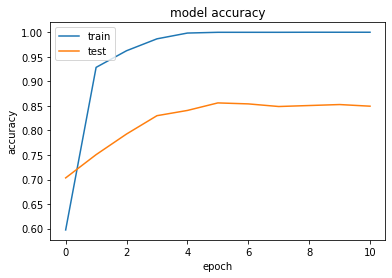

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

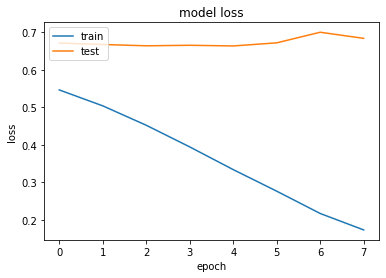

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()